## Activations for a single image

First, load the image and display it.

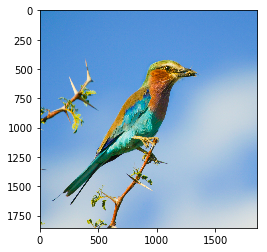

In [1]:
%matplotlib inline
import os

import numpy as np
from PIL import Image
from matplotlib import pyplot

stimuli_path = 'image.jpg'
pyplot.imshow(np.array(Image.open(stimuli_path)))
pyplot.show()


We can now 
(1) use a pre-defined model, (2) specify the layers we want to extract features from and (3) retrieve the activations from the model.

For pre-defined models, there is a default selection of layers in `candidate_models.models.implementations.model_layers`.

### Pre-defined model

In [2]:
from candidate_models.base_models import base_model_pool
from candidate_models.model_commitments import model_layers

model = base_model_pool['resnet-101_v2']  # (1)
layers = model_layers['resnet-101_v2'][-2:]  # (2)
activations = model(stimuli=[stimuli_path], layers=layers)  # (3)


INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Restoring parameters from /braintree/home/msch/.candidate_models/model-weights/slim/resnet-101_v2/resnet_v2_101.ckpt


activations: 100%|██████████| 64/64 [00:03<00:00, 17.49it/s]


`activations` is now an xarray DataArray with two dimensions `stimulus_path` and `neuroid` 
as well as the additional metadata `layer` on the `neuroid`.


In [3]:
print("\n", activations)


 <xarray.NeuroidAssembly (stimulus_path: 1, neuroid: 206848)>
array([[-130.05058, -100.87107, -147.45302, ...,    0.     ,    0.     ,
           0.     ]], dtype=float32)
Coordinates:
  * stimulus_path  (stimulus_path) <U9 'image.jpg'
  * neuroid        (neuroid) MultiIndex
  - neuroid_id     (neuroid) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  - layer          (neuroid) object 'resnet_v2_101/block4/unit_3/bottleneck_v2' ...


### Custom Pytorch Model

Let's say you have a custom PyTorch model:

In [4]:
import numpy as np
import torch
from torch import nn


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=2, kernel_size=3)
        self.relu1 = torch.nn.ReLU()
        linear_input_size = np.power((224 - 3 + 2 * 0) / 1 + 1, 2) * 2
        self.linear = torch.nn.Linear(int(linear_input_size), 1000)
        self.relu2 = torch.nn.ReLU()  # can't get named ReLU output otherwise

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = self.relu2(x)
        return x


You can now pass the model to the Pytorch wrapper together with a preprocessing function:

In [6]:
import functools
from model_tools.activations.pytorch import PytorchWrapper, load_preprocess_images

preprocessing = functools.partial(load_preprocess_images, image_size=224)
wrapper = PytorchWrapper(identifier='my-model', model=MyModel(), preprocessing=preprocessing)

Now you can extract activations for a given list of layers:

In [7]:
activations = wrapper(stimuli=[stimuli_path], layers=['linear', 'relu2'])
print(activations)

activations: 100%|██████████| 64/64 [00:06<00:00,  9.22it/s]

<xarray.NeuroidAssembly (stimulus_path: 1, neuroid: 2000)>
array([[-0.060337, -0.164952,  0.262145, ...,  0.      ,  0.34054 ,  0.      ]],
      dtype=float32)
Coordinates:
  * stimulus_path  (stimulus_path) <U9 'image.jpg'
  * neuroid        (neuroid) MultiIndex
  - neuroid_id     (neuroid) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  - layer          (neuroid) object 'linear' 'linear' 'linear' 'linear' ...


### Custom Tensorflow model

In [10]:
from model_tools.activations.tensorflow import TensorflowSlimWrapper, load_resize_image
import tensorflow as tf

slim = tf.contrib.slim
tf.reset_default_graph()

image_size = 224
placeholder = tf.placeholder(dtype=tf.string, shape=[64])
preprocess = lambda image_path: load_resize_image(image_path, image_size)
preprocess = tf.map_fn(preprocess, placeholder, dtype=tf.float32)

with tf.variable_scope('my_model', values=[preprocess]) as sc:
    end_points_collection = sc.original_name_scope + '_end_points'
    # Collect outputs for conv2d, fully_connected and max_pool2d.
    with slim.arg_scope([slim.conv2d, slim.fully_connected, slim.max_pool2d],
                        outputs_collections=[end_points_collection]):
        net = slim.conv2d(preprocess, 64, [11, 11], 4, padding='VALID', scope='conv1')
        net = slim.max_pool2d(net, [5, 5], 5, scope='pool1')
        net = slim.max_pool2d(net, [3, 3], 2, scope='pool2')
        net = slim.flatten(net, scope='flatten')
        net = slim.fully_connected(net, 1000, scope='logits')
        endpoints = slim.utils.convert_collection_to_dict(end_points_collection)

session = tf.Session()
session.run(tf.initialize_all_variables())
wrapper = TensorflowSlimWrapper(identifier='tf-custom', labels_offset=0, 
                                endpoints=endpoints, inputs=placeholder, session=session)
activations = wrapper(stimuli=[stimuli_path], layers=['my_model/pool2'])
print(activations)

activations: 100%|██████████| 64/64 [00:00<00:00, 125.82it/s]

<xarray.NeuroidAssembly (stimulus_path: 1, neuroid: 1024)>
array([[  0.    ,   0.    ,   0.    , ..., 142.9336,   0.    ,   0.    ]],
      dtype=float32)
Coordinates:
  * stimulus_path  (stimulus_path) <U9 'image.jpg'
  * neuroid        (neuroid) MultiIndex
  - neuroid_id     (neuroid) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  - layer          (neuroid) object 'my_model/pool2' 'my_model/pool2' ...
